In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [5]:
runs = [304125,302263,304508]

with open('good_data_WINDOW.pickle', 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

WINDOW = 10

1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224


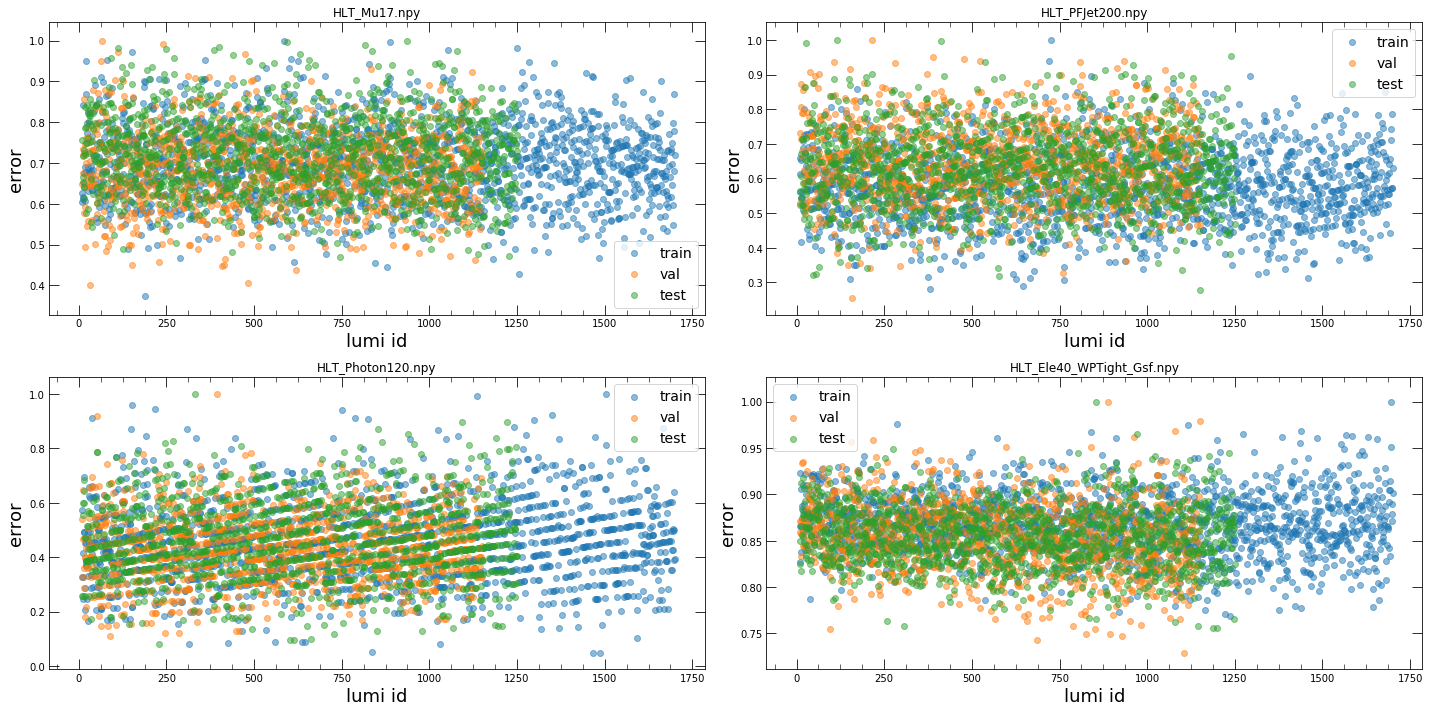

In [6]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[20,10])
              
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

## Simple Autoencoder

In [7]:
model_name = "simplest"

In [8]:
# Define the architecture

_input = Input(shape=(4*WINDOW,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(4*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 40)                0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 123       
_________________________________________________________________
reconstructed (Dense)        (None, 40)                160       
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________


Train on 1660 samples, validate on 1120 samples
Epoch 1/1000
 - 0s - loss: 5978.7821 - val_loss: 5898.2039
Epoch 2/1000
 - 0s - loss: 5835.3512 - val_loss: 5760.3357
Epoch 3/1000
 - 0s - loss: 5698.8076 - val_loss: 5622.9378
Epoch 4/1000
 - 0s - loss: 5563.3020 - val_loss: 5487.6657
Epoch 5/1000
 - 0s - loss: 5428.7496 - val_loss: 5354.1221
Epoch 6/1000
 - 0s - loss: 5296.6473 - val_loss: 5223.1410
Epoch 7/1000
 - 0s - loss: 5167.0659 - val_loss: 5095.0793
Epoch 8/1000
 - 0s - loss: 5040.2987 - val_loss: 4969.9562
Epoch 9/1000
 - 0s - loss: 4916.5401 - val_loss: 4847.7657
Epoch 10/1000
 - 0s - loss: 4795.5025 - val_loss: 4728.5153
Epoch 11/1000
 - 0s - loss: 4677.6096 - val_loss: 4611.5212
Epoch 12/1000
 - 0s - loss: 4561.8814 - val_loss: 4498.0801
Epoch 13/1000
 - 0s - loss: 4449.6105 - val_loss: 4387.5125
Epoch 14/1000
 - 0s - loss: 4340.2983 - val_loss: 4279.1420
Epoch 15/1000
 - 0s - loss: 4233.1198 - val_loss: 4174.2151
Epoch 16/1000
 - 0s - loss: 4129.4112 - val_loss: 4072.0427
E

Epoch 139/1000
 - 0s - loss: 374.0379 - val_loss: 371.7834
Epoch 140/1000
 - 0s - loss: 368.4814 - val_loss: 366.2757
Epoch 141/1000
 - 0s - loss: 363.0258 - val_loss: 360.8651
Epoch 142/1000
 - 0s - loss: 357.6682 - val_loss: 355.5575
Epoch 143/1000
 - 0s - loss: 352.4141 - val_loss: 350.3469
Epoch 144/1000
 - 0s - loss: 347.2491 - val_loss: 345.2318
Epoch 145/1000
 - 0s - loss: 342.1831 - val_loss: 340.2093
Epoch 146/1000
 - 0s - loss: 337.2113 - val_loss: 335.2771
Epoch 147/1000
 - 0s - loss: 332.3225 - val_loss: 330.4344
Epoch 148/1000
 - 0s - loss: 327.5273 - val_loss: 325.6787
Epoch 149/1000
 - 0s - loss: 322.8160 - val_loss: 321.0046
Epoch 150/1000
 - 0s - loss: 318.1881 - val_loss: 316.4172
Epoch 151/1000
 - 0s - loss: 313.6395 - val_loss: 311.9117
Epoch 152/1000
 - 0s - loss: 309.1805 - val_loss: 307.4850
Epoch 153/1000
 - 0s - loss: 304.7942 - val_loss: 303.1368
Epoch 154/1000
 - 0s - loss: 300.4877 - val_loss: 298.8648
Epoch 155/1000
 - 0s - loss: 296.2556 - val_loss: 294.66

Epoch 280/1000
 - 0s - loss: 68.2605 - val_loss: 68.1292
Epoch 281/1000
 - 0s - loss: 67.5911 - val_loss: 67.4625
Epoch 282/1000
 - 0s - loss: 66.9303 - val_loss: 66.8041
Epoch 283/1000
 - 0s - loss: 66.2771 - val_loss: 66.1537
Epoch 284/1000
 - 0s - loss: 65.6322 - val_loss: 65.5109
Epoch 285/1000
 - 0s - loss: 64.9944 - val_loss: 64.8758
Epoch 286/1000
 - 0s - loss: 64.3647 - val_loss: 64.2485
Epoch 287/1000
 - 0s - loss: 63.7430 - val_loss: 63.6285
Epoch 288/1000
 - 0s - loss: 63.1278 - val_loss: 63.0156
Epoch 289/1000
 - 0s - loss: 62.5204 - val_loss: 62.4105
Epoch 290/1000
 - 0s - loss: 61.9198 - val_loss: 61.8124
Epoch 291/1000
 - 0s - loss: 61.3269 - val_loss: 61.2213
Epoch 292/1000
 - 0s - loss: 60.7408 - val_loss: 60.6371
Epoch 293/1000
 - 0s - loss: 60.1614 - val_loss: 60.0601
Epoch 294/1000
 - 0s - loss: 59.5894 - val_loss: 59.4898
Epoch 295/1000
 - 0s - loss: 59.0237 - val_loss: 58.9261
Epoch 296/1000
 - 0s - loss: 58.4648 - val_loss: 58.3691
Epoch 297/1000
 - 0s - loss: 57

Epoch 424/1000
 - 0s - loss: 19.9936 - val_loss: 19.9930
Epoch 425/1000
 - 0s - loss: 19.8450 - val_loss: 19.8447
Epoch 426/1000
 - 0s - loss: 19.6978 - val_loss: 19.6976
Epoch 427/1000
 - 0s - loss: 19.5518 - val_loss: 19.5518
Epoch 428/1000
 - 0s - loss: 19.4072 - val_loss: 19.4074
Epoch 429/1000
 - 0s - loss: 19.2638 - val_loss: 19.2642
Epoch 430/1000
 - 0s - loss: 19.1218 - val_loss: 19.1223
Epoch 431/1000
 - 0s - loss: 18.9810 - val_loss: 18.9816
Epoch 432/1000
 - 0s - loss: 18.8414 - val_loss: 18.8423
Epoch 433/1000
 - 0s - loss: 18.7031 - val_loss: 18.7041
Epoch 434/1000
 - 0s - loss: 18.5660 - val_loss: 18.5672
Epoch 435/1000
 - 0s - loss: 18.4301 - val_loss: 18.4315
Epoch 436/1000
 - 0s - loss: 18.2955 - val_loss: 18.2969
Epoch 437/1000
 - 0s - loss: 18.1621 - val_loss: 18.1636
Epoch 438/1000
 - 0s - loss: 18.0297 - val_loss: 18.0314
Epoch 439/1000
 - 0s - loss: 17.8985 - val_loss: 17.9004
Epoch 440/1000
 - 0s - loss: 17.7686 - val_loss: 17.7706
Epoch 441/1000
 - 0s - loss: 17

Epoch 570/1000
 - 0s - loss: 7.4550 - val_loss: 7.4619
Epoch 571/1000
 - 0s - loss: 7.4091 - val_loss: 7.4160
Epoch 572/1000
 - 0s - loss: 7.3636 - val_loss: 7.3705
Epoch 573/1000
 - 0s - loss: 7.3184 - val_loss: 7.3253
Epoch 574/1000
 - 0s - loss: 7.2736 - val_loss: 7.2804
Epoch 575/1000
 - 0s - loss: 7.2290 - val_loss: 7.2359
Epoch 576/1000
 - 0s - loss: 7.1848 - val_loss: 7.1916
Epoch 577/1000
 - 0s - loss: 7.1409 - val_loss: 7.1477
Epoch 578/1000
 - 0s - loss: 7.0973 - val_loss: 7.1041
Epoch 579/1000
 - 0s - loss: 7.0540 - val_loss: 7.0608
Epoch 580/1000
 - 0s - loss: 7.0111 - val_loss: 7.0178
Epoch 581/1000
 - 0s - loss: 6.9684 - val_loss: 6.9752
Epoch 582/1000
 - 0s - loss: 6.9260 - val_loss: 6.9328
Epoch 583/1000
 - 0s - loss: 6.8840 - val_loss: 6.8907
Epoch 584/1000
 - 0s - loss: 6.8422 - val_loss: 6.8490
Epoch 585/1000
 - 0s - loss: 6.8008 - val_loss: 6.8075
Epoch 586/1000
 - 0s - loss: 6.7596 - val_loss: 6.7663
Epoch 587/1000
 - 0s - loss: 6.7187 - val_loss: 6.7254
Epoch 588/

Epoch 719/1000
 - 0s - loss: 3.1616 - val_loss: 3.1659
Epoch 720/1000
 - 0s - loss: 3.1445 - val_loss: 3.1488
Epoch 721/1000
 - 0s - loss: 3.1276 - val_loss: 3.1318
Epoch 722/1000
 - 0s - loss: 3.1108 - val_loss: 3.1150
Epoch 723/1000
 - 0s - loss: 3.0940 - val_loss: 3.0982
Epoch 724/1000
 - 0s - loss: 3.0774 - val_loss: 3.0816
Epoch 725/1000
 - 0s - loss: 3.0609 - val_loss: 3.0650
Epoch 726/1000
 - 0s - loss: 3.0444 - val_loss: 3.0486
Epoch 727/1000
 - 0s - loss: 3.0281 - val_loss: 3.0322
Epoch 728/1000
 - 0s - loss: 3.0119 - val_loss: 3.0160
Epoch 729/1000
 - 0s - loss: 2.9957 - val_loss: 2.9998
Epoch 730/1000
 - 0s - loss: 2.9797 - val_loss: 2.9838
Epoch 731/1000
 - 0s - loss: 2.9637 - val_loss: 2.9678
Epoch 732/1000
 - 0s - loss: 2.9479 - val_loss: 2.9519
Epoch 733/1000
 - 0s - loss: 2.9321 - val_loss: 2.9362
Epoch 734/1000
 - 0s - loss: 2.9165 - val_loss: 2.9205
Epoch 735/1000
 - 0s - loss: 2.9009 - val_loss: 2.9049
Epoch 736/1000
 - 0s - loss: 2.8855 - val_loss: 2.8894
Epoch 737/

Epoch 868/1000
 - 0s - loss: 1.4654 - val_loss: 1.4674
Epoch 869/1000
 - 0s - loss: 1.4581 - val_loss: 1.4601
Epoch 870/1000
 - 0s - loss: 1.4509 - val_loss: 1.4529
Epoch 871/1000
 - 0s - loss: 1.4438 - val_loss: 1.4457
Epoch 872/1000
 - 0s - loss: 1.4366 - val_loss: 1.4386
Epoch 873/1000
 - 0s - loss: 1.4296 - val_loss: 1.4315
Epoch 874/1000
 - 0s - loss: 1.4225 - val_loss: 1.4245
Epoch 875/1000
 - 0s - loss: 1.4155 - val_loss: 1.4174
Epoch 876/1000
 - 0s - loss: 1.4085 - val_loss: 1.4105
Epoch 877/1000
 - 0s - loss: 1.4016 - val_loss: 1.4035
Epoch 878/1000
 - 0s - loss: 1.3947 - val_loss: 1.3966
Epoch 879/1000
 - 0s - loss: 1.3879 - val_loss: 1.3897
Epoch 880/1000
 - 0s - loss: 1.3810 - val_loss: 1.3829
Epoch 881/1000
 - 0s - loss: 1.3743 - val_loss: 1.3761
Epoch 882/1000
 - 0s - loss: 1.3675 - val_loss: 1.3694
Epoch 883/1000
 - 0s - loss: 1.3608 - val_loss: 1.3626
Epoch 884/1000
 - 0s - loss: 1.3541 - val_loss: 1.3560
Epoch 885/1000
 - 0s - loss: 1.3475 - val_loss: 1.3493
Epoch 886/

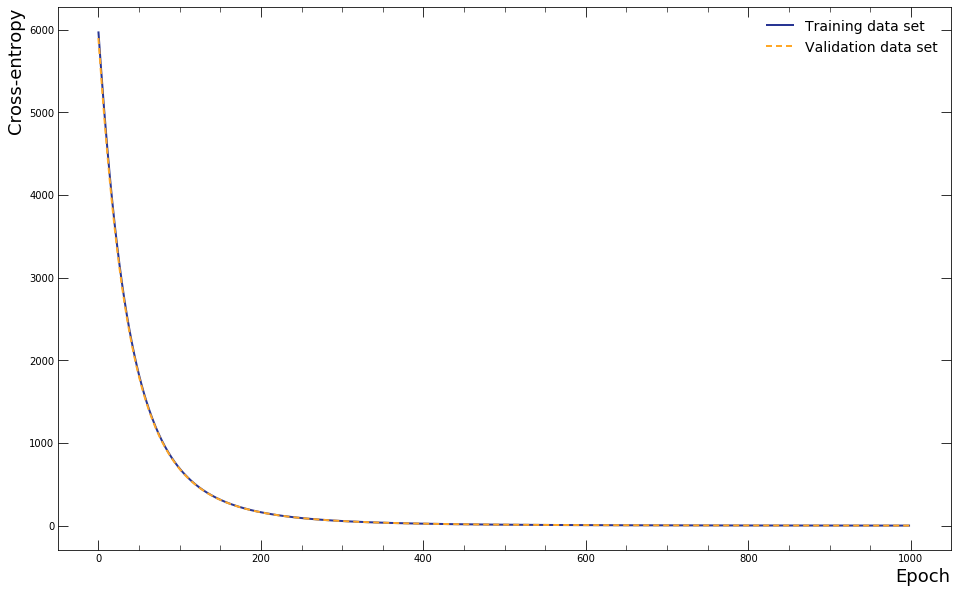

In [9]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

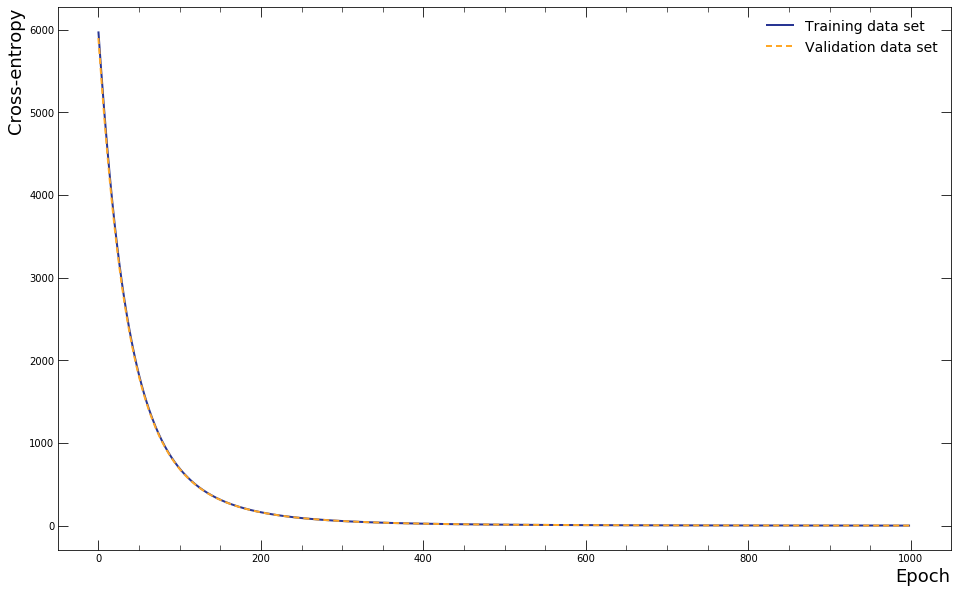

In [10]:
plot_loss(history)

In [11]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [31]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

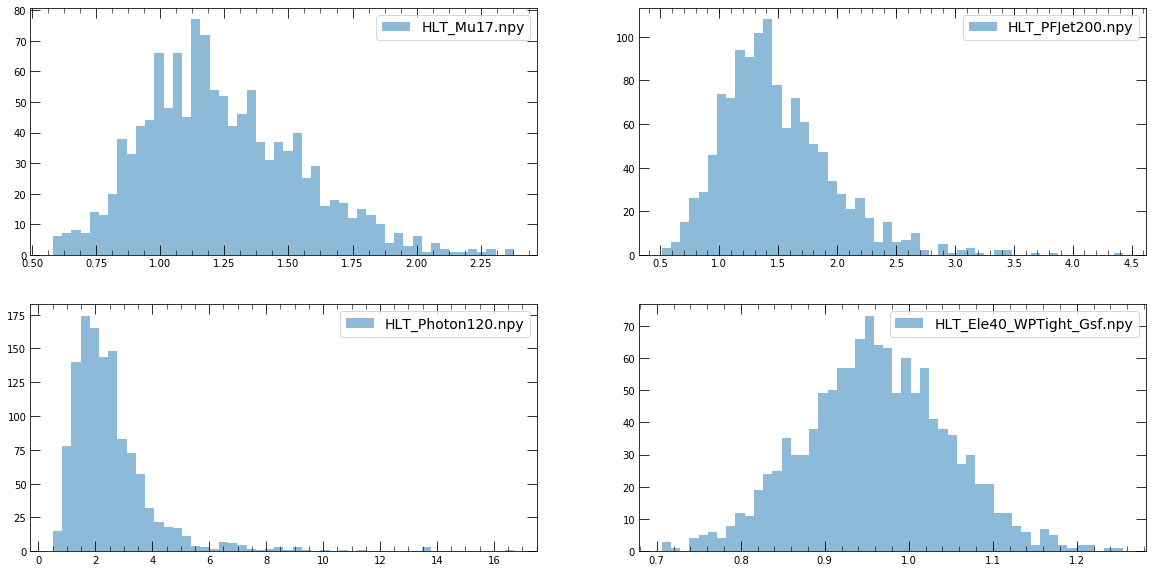

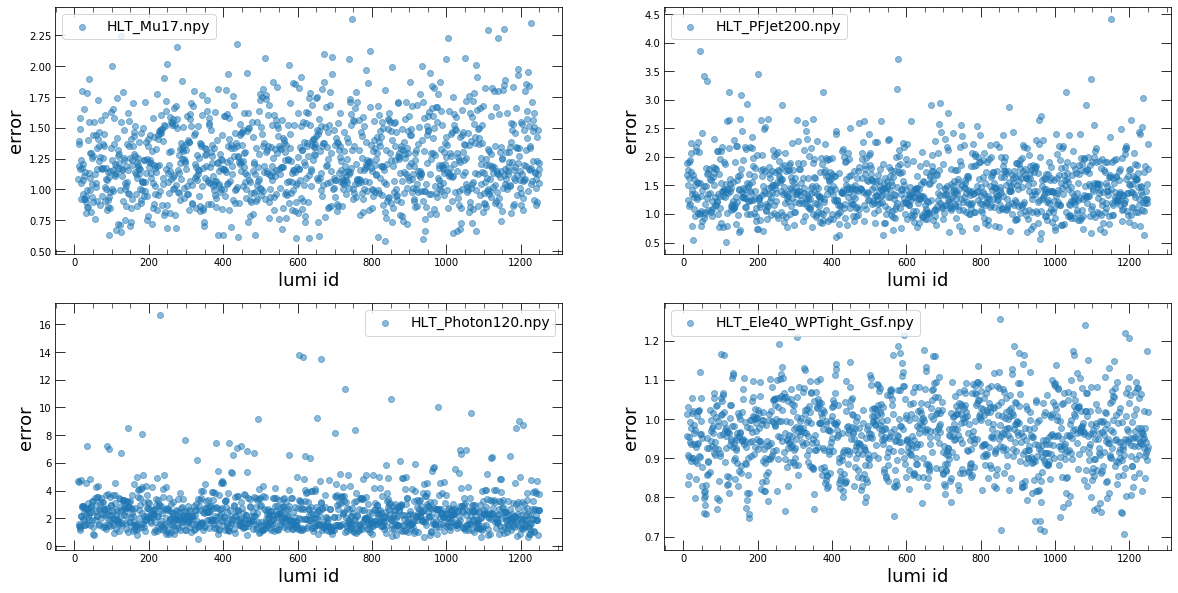

In [33]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

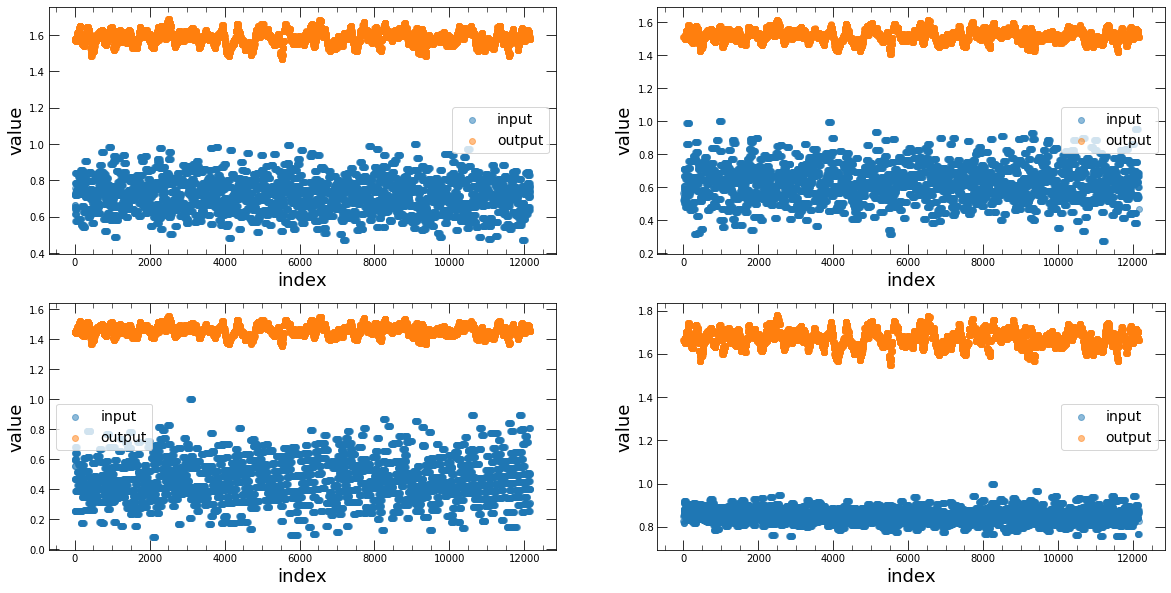

In [14]:
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,inp[i],label='input',alpha=.5)
    plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()    

plt.show()

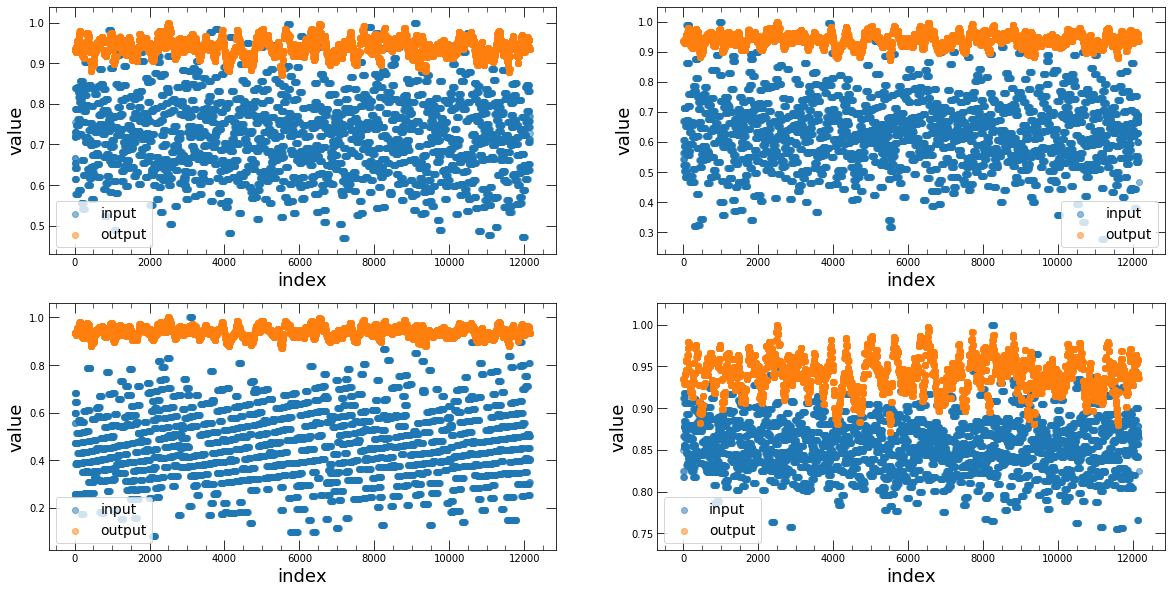

In [15]:
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,inp[i],label='input',alpha=.5)
    plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()    

plt.show()

In [16]:
for i in range(len(outp)):
    for j in range(i+1,len(outp)):
        print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

0.628015398979187
0.3838704228401184
-0.13458627462387085
-0.2441449761390686
-0.7626016736030579
-0.5184566974639893


## Fake Bad Data

In [17]:
bad = np.array(data[str(runs[0])]['bad_samples'])

In [18]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [19]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])

1669 1669


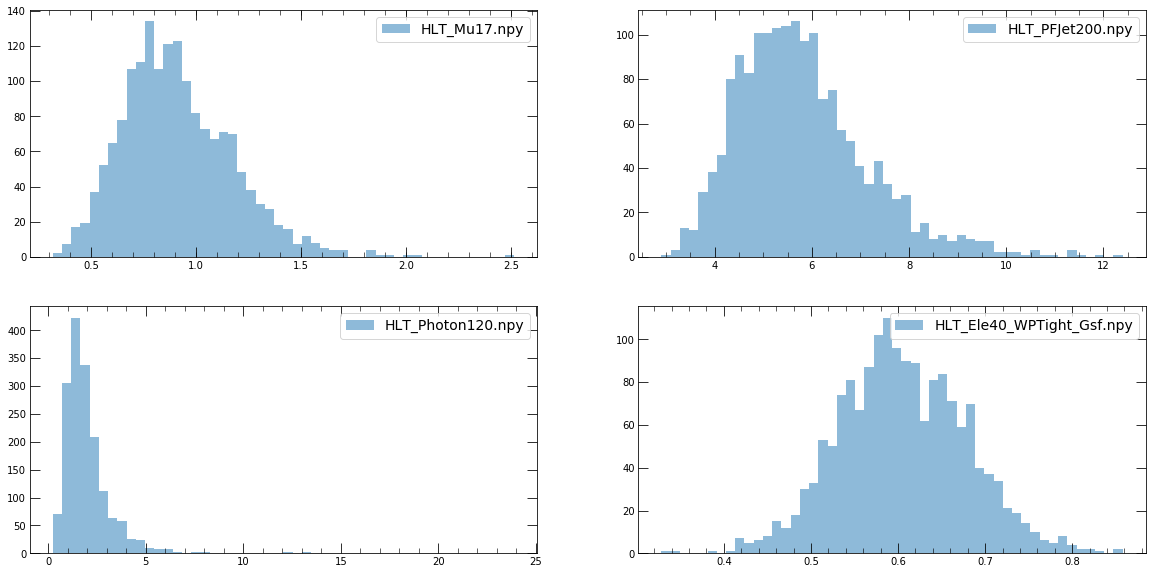

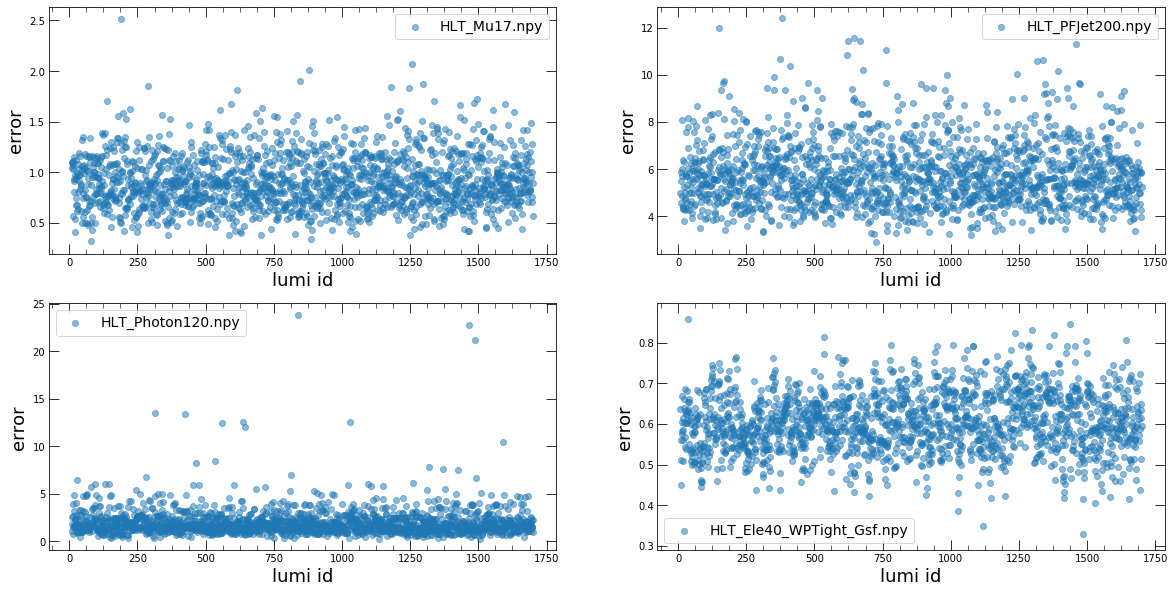

In [20]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat_bad[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[0])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat_bad[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

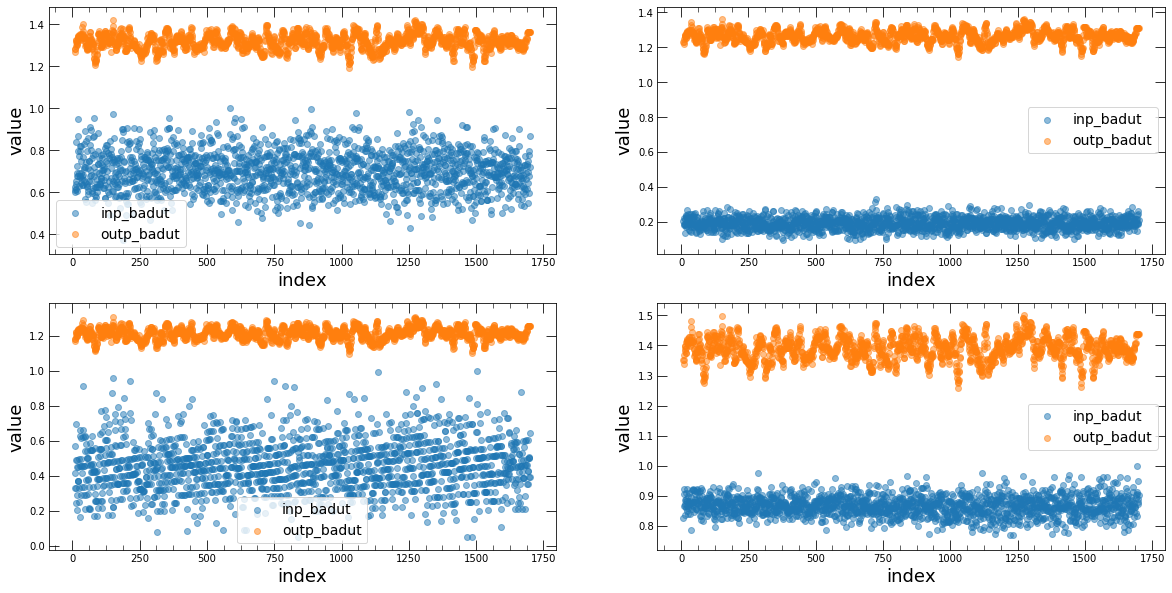

In [21]:
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
    plt.scatter(lumi,outp_bad[i],label='outp_badut',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()    

plt.show()

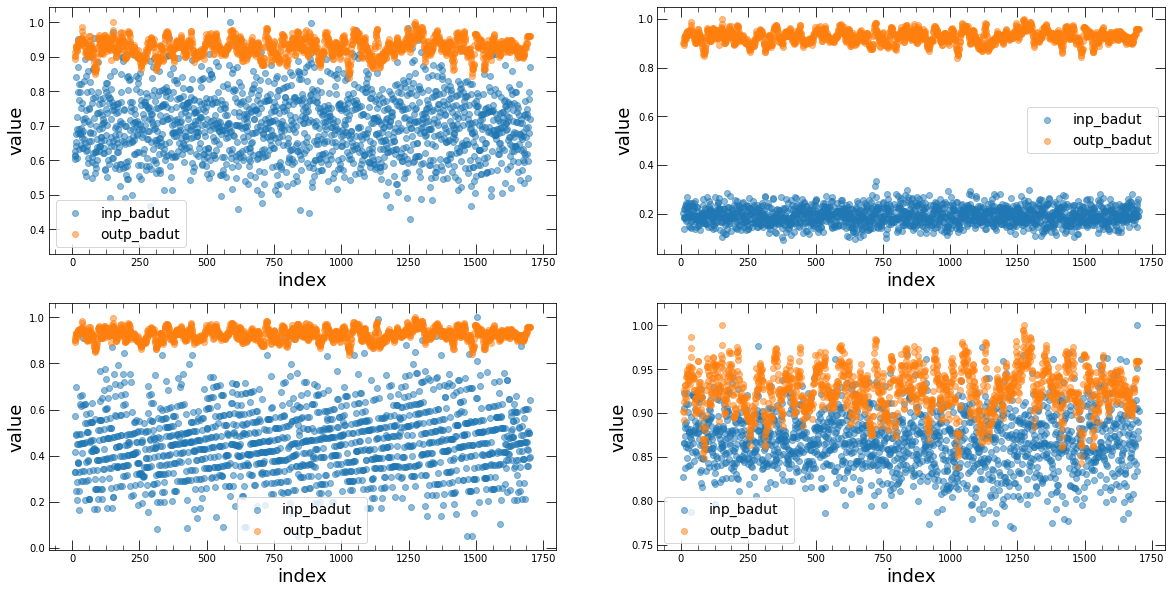

In [22]:
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
    plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()    

plt.show()

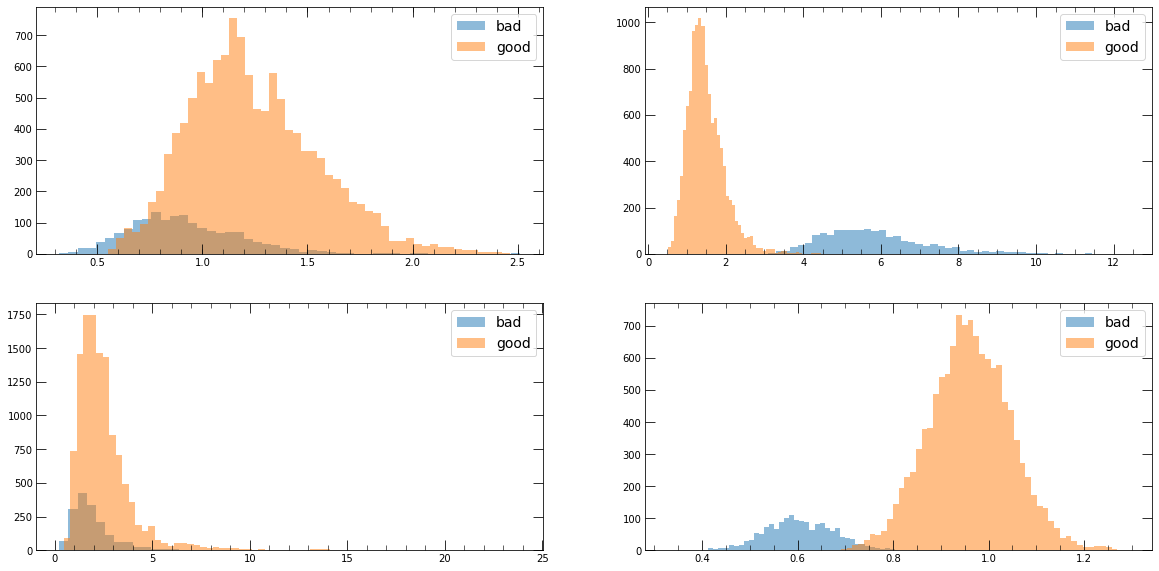

In [23]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.legend()

# lumi = data[str(runs[0])]['lumiid'] 
# print(len(error_reformat_bad[0]),len(lumi))
# #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
#     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
#     plt.xlabel('lumi id')
#     plt.ylabel('error')
#     plt.legend()    

plt.show()

## Fake Bad Data - ALL

In [24]:
bad = np.array(data[str(runs[0])]['all_bad_samples'])

In [25]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [26]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1669 1669


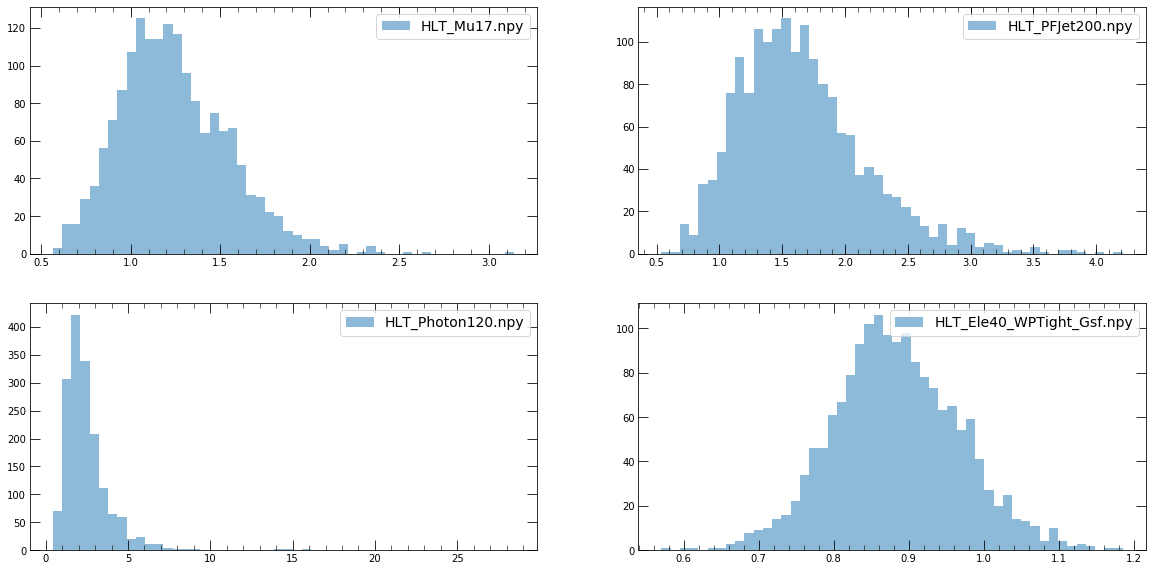

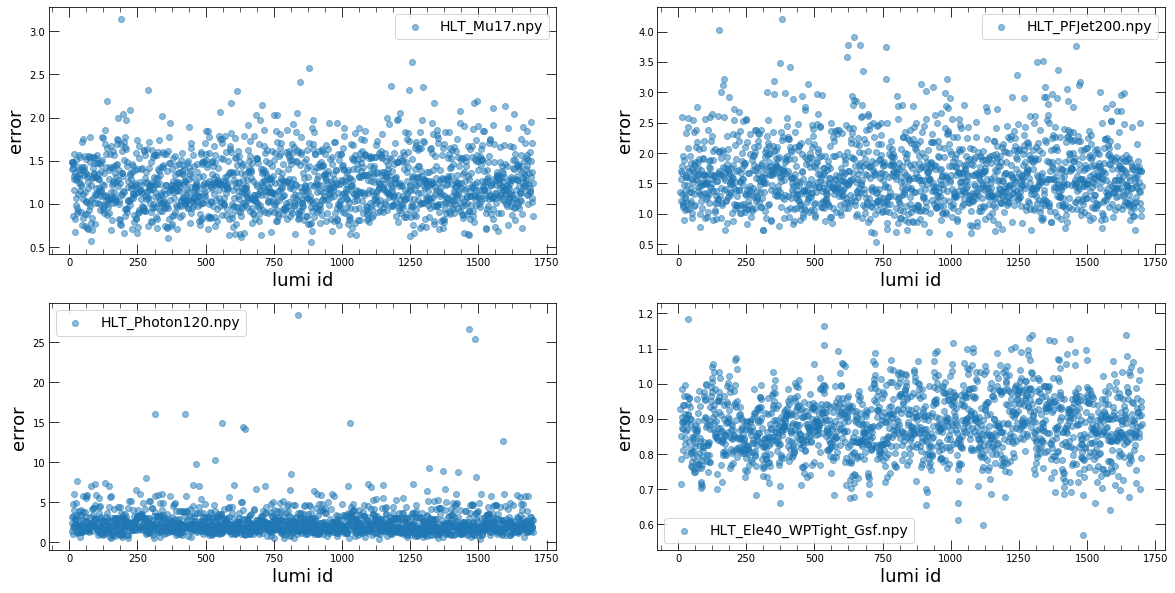

In [27]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat_bad[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[0])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat_bad[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

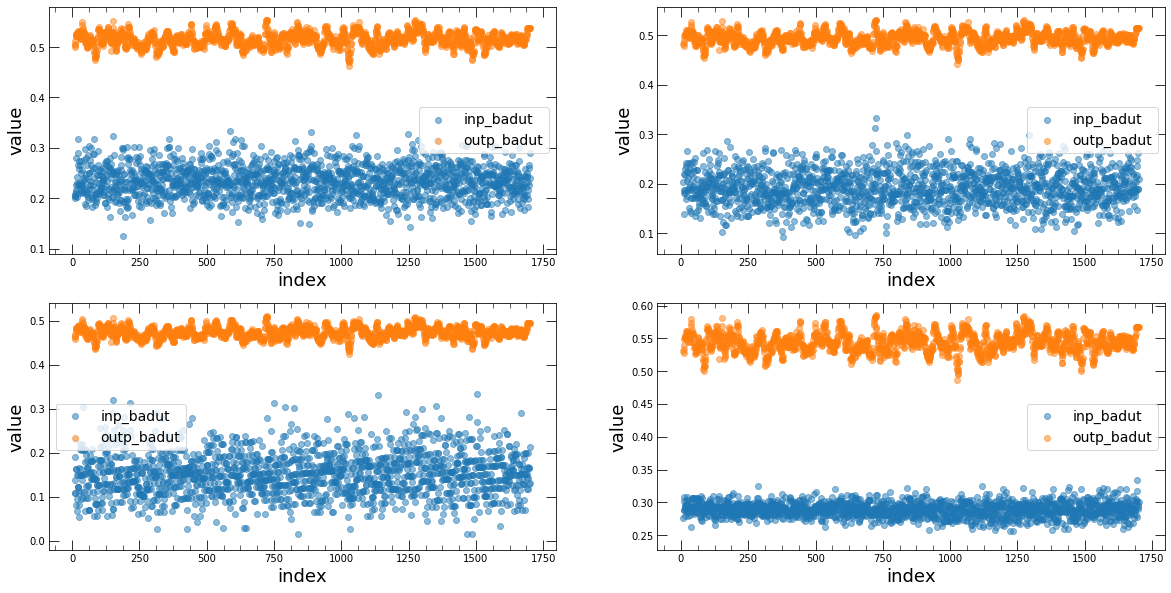

In [28]:
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
    plt.scatter(lumi,outp_bad[i],label='outp_badut',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()    

plt.show()

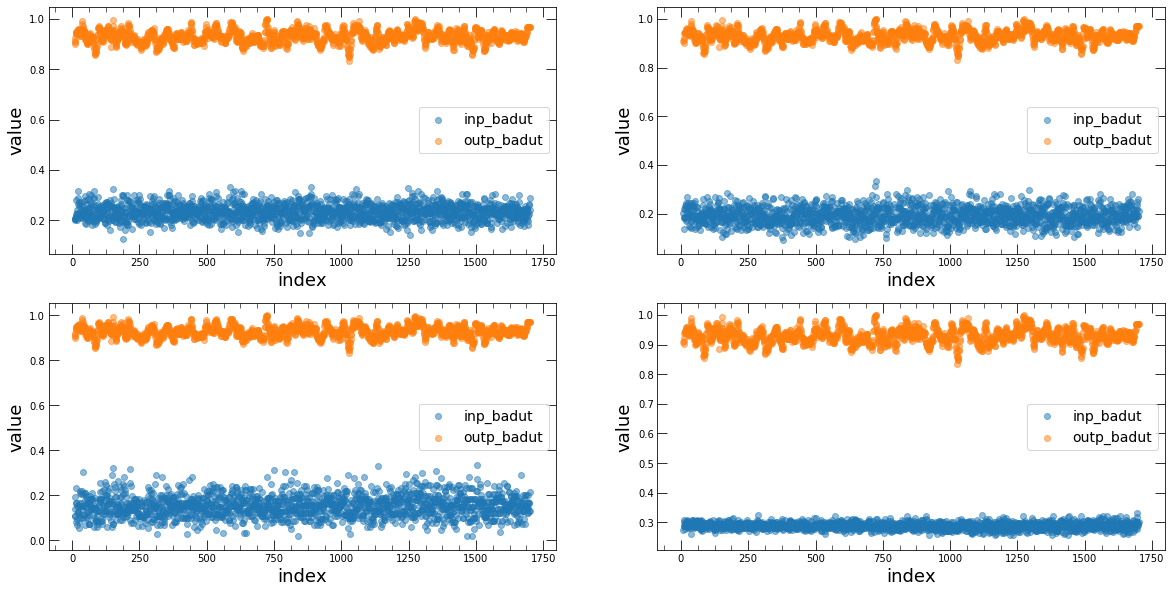

In [29]:
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
    plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()    

plt.show()

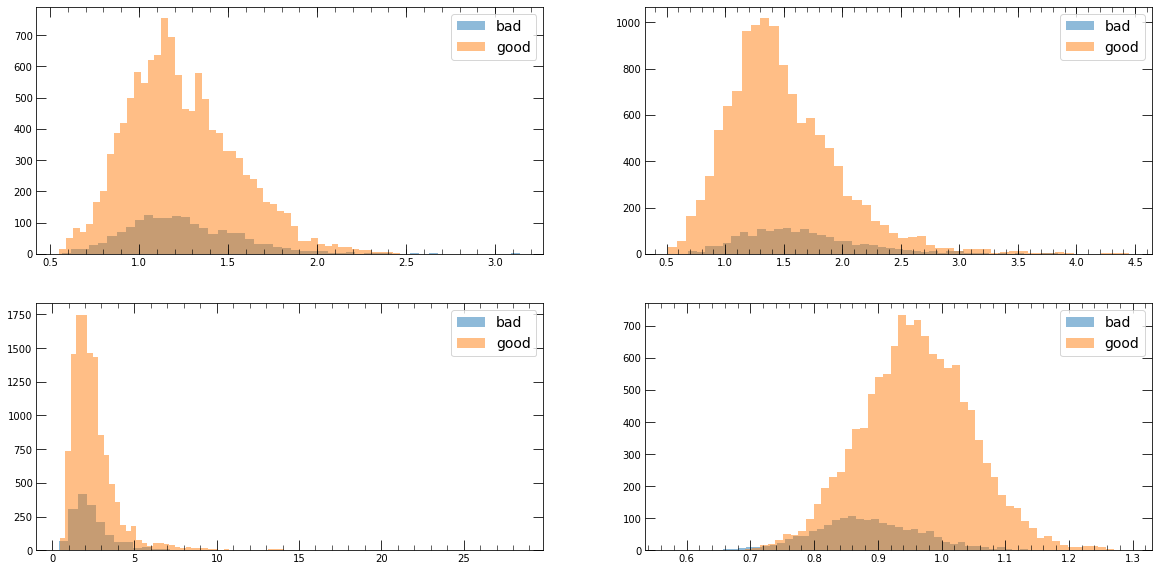

In [30]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.legend()

# lumi = data[str(runs[0])]['lumiid'] 
# print(len(error_reformat_bad[0]),len(lumi))
# #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
#     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
#     plt.xlabel('lumi id')
#     plt.ylabel('error')
#     plt.legend()    

plt.show()